In [ ]:
# code from https://roberttlange.github.io/posts/2020/03/blog-post-10/
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Generate key which is used to generate jax.random numbers
key = jax.random.PRNGKey(1)

In [ ]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return jnp.maximum(0, x)

jit_ReLU = jit(ReLU)

In [ ]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = jax.random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [jax.random.normal(key, (hidden_dim, feature_dim)),
          jax.random.normal(key, (hidden_dim, ))]

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(jnp.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(jnp.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = jnp.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

In [ ]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers

import torch
from torchvision import datasets, transforms
import time

# Set the PyTorch Data Loader for the training & test set
train_batch_size = 32
test_batch_size = 512

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

In [ ]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = jax.random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = jax.random.split(key)
        return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

@jit
def perturb_params(params,seed):
    key = jax.random.PRNGKey(seed)
    # return [jax.tree_util.tree_map(lambda x : jax.random.normal(key, x.shape), layer) for layer in params]
    return [jax.tree_util.tree_map(lambda x : jax.random.rademacher(key, x.shape, dtype=np.float32), layer) for layer in params]
@jit
def fwd_grad(jvp_, params_tan):
    return [jax.tree_util.tree_map(lambda x : x*jvp_, layer) for layer in params_tan]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [ ]:
# perturb_params(params, 0)[0][0][0][0]

In [ ]:
@jit
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [ ]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
@jit
def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -jnp.sum(preds * targets)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = jnp.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(jnp.array(target), num_classes)

        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(batch_forward(params, images), axis=1)
        acc_total += jnp.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

In [ ]:
from functools import partial
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

@jit
def fwd_update(params, params_tan, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    f = partial(loss, in_arrays=x, targets=y)
    value, jvp_ = jax.jvp(f, (params,), (params_tan,))
    grads = fwd_grad(jvp_, params_tan)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value


In [ ]:
num_classes = 10
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP", method = 'reverse'):
    seed = 0
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_train_time, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after jax.random init
    test_acc = accuracy(params, test_loader)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        bar = tqdm(total = len(train_loader))
        for batch_idx, (data, target) in enumerate(train_loader):
            bar.update(1)
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = jnp.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the ijnput required for the CNN
                x = jnp.array(data)
            y = one_hot(jnp.array(target), num_classes)

            if method == 'reverse':
                params, opt_state, loss = update(params, x, y, opt_state)

            if method == 'forward':                
                params_tan = perturb_params(params, seed)
                seed += 1
                params, opt_state, loss = fwd_update(params, params_tan, x, y, opt_state)

            train_loss.append(loss)

        epoch_time = time.time() - start_time
        test_acc = accuracy(params, test_loader)
        log_train_time.append(epoch_time)
        log_acc_test.append(test_acc)
        print("Epoch {} | Time: {:0.2f} | Train Loss: {:0.3f} | Test Accu: {:0.3f}".format(epoch+1, epoch_time, sum(train_loss[-len(train_loader):])/len(train_loader),test_acc))
    return train_loss, log_acc_test, log_train_time

In [ ]:
# Defining an optimizer in Jax
step_size = 1e-3
num_epochs = 10

In [ ]:
params = initialize_mlp(layer_sizes, key)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
fwd_train_loss, fwd_test_log, fwd_log_time = run_mnist_training_loop(num_epochs, opt_state, net_type="MLP", method = 'forward')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 | Time: 32.64 | Train Loss: 67.166 | Test Accu: 0.584


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 | Time: 28.59 | Train Loss: 55.048 | Test Accu: 0.706


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 | Time: 30.15 | Train Loss: 44.349 | Test Accu: 0.737


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 | Time: 29.47 | Train Loss: 36.695 | Test Accu: 0.772


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 | Time: 28.57 | Train Loss: 31.498 | Test Accu: 0.797


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 | Time: 28.59 | Train Loss: 27.163 | Test Accu: 0.816


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 | Time: 28.65 | Train Loss: 24.459 | Test Accu: 0.817


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 | Time: 28.73 | Train Loss: 22.633 | Test Accu: 0.830


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 | Time: 28.75 | Train Loss: 20.483 | Test Accu: 0.837


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 | Time: 28.68 | Train Loss: 19.401 | Test Accu: 0.829


In [ ]:
params = initialize_mlp(layer_sizes, key)
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
rev_train_loss, rev_test_log, rev_log_time = run_mnist_training_loop(num_epochs, opt_state, net_type="MLP", method = 'reverse')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 | Time: 29.69 | Train Loss: 5.997 | Test Accu: 0.965


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 | Time: 27.99 | Train Loss: 2.485 | Test Accu: 0.974


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 | Time: 27.94 | Train Loss: 1.654 | Test Accu: 0.980


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 | Time: 27.96 | Train Loss: 1.228 | Test Accu: 0.981


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 | Time: 28.43 | Train Loss: 0.875 | Test Accu: 0.981


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 | Time: 28.12 | Train Loss: 0.770 | Test Accu: 0.981


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 | Time: 29.12 | Train Loss: 0.562 | Test Accu: 0.980


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 | Time: 28.64 | Train Loss: 0.530 | Test Accu: 0.982


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 | Time: 28.33 | Train Loss: 0.443 | Test Accu: 0.982


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 | Time: 28.31 | Train Loss: 0.463 | Test Accu: 0.983


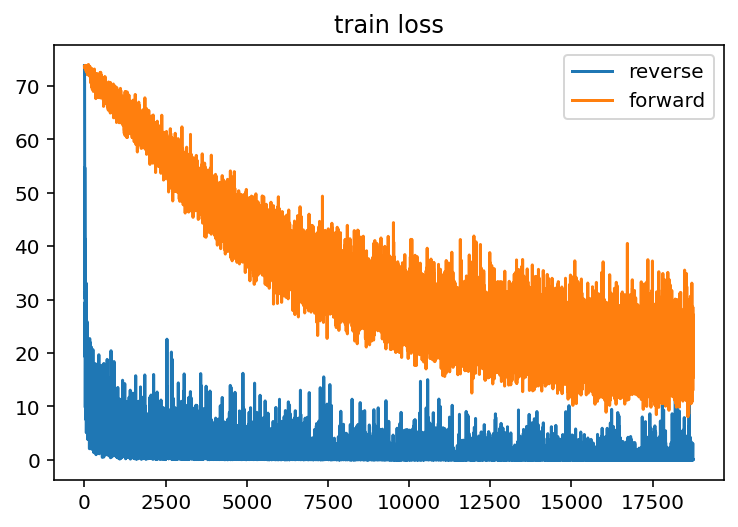

In [ ]:
plt.plot(rev_train_loss, label='reverse')
plt.plot(fwd_train_loss, label='forward')
plt.title('train loss')
plt.legend()

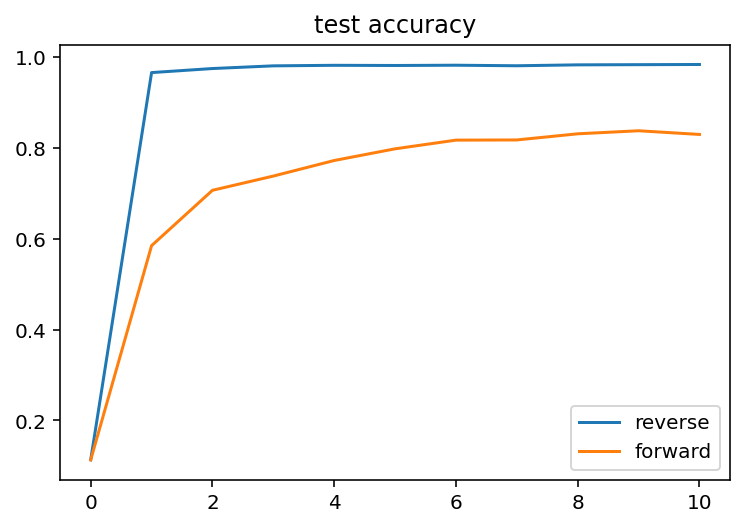

In [ ]:
plt.plot(rev_test_log, label='reverse')
plt.plot(fwd_test_log, label='forward')
plt.title('test accuracy')
plt.legend()